In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a435e6cb581d8cc78c876fefe028aee708cd9711ac6e37f60a1f5c3e79ea70f5
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib as mpl

Efficient Frontier

In [ ]:
tickers = ['V', 'JPM', 'JNJ', 'WMT', 'KO']
adj_close = pd.DataFrame()
for item in tickers:
  adj_close[item] = yf.download(item, start='2018-09-15')['Adj Close']
daily_returns = adj_close.pct_change()
daily_returns = daily_returns.dropna(axis=0)
print(daily_returns.head())
daily_cov = daily_returns.cov().values
annual_returns = daily_returns.mean() * 250
covmat = daily_cov*250
print(covmat)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   V       JPM       JNJ       WMT        KO
Date                                                        
2018-09-18  0.009919  0.004041  0.004144  0.006433 -0.008420
2018-09-19 -0.001422  0.029046 -0.000569 -0.001991  0.000653
2018-09-20  0.012346  0.008587  0.010822  0.005355  0.014795
2018-09-21  0.005427 -0.006575  0.006339  0.001567 -0.001286
2018-09-24 -0.006265 -0.009588 -0.016867 -0.010219 -0.010949
[[0.09256043 0.07164809 0.03653184 0.02675109 0.04413246]
 [0.07164809 0.12582436 0.03684324 0.02547469 0.05027194]
 [0.03653184 0.03684324 0.05082889 0.02423205 0.03098592]
 [0.02675109 0.02547469 0.02423205 0.05078172 0.021361

In [ ]:
p_returns = []
p_volatility = []
p_weights = []
n_assets = len(tickers)
n_ports = 50000

In [ ]:
for s in range(n_ports):
  weight = np.random.random(n_assets)
  weight /= np.sum(weight)
  ret = np.dot(weight, annual_returns)
  vol = np.sqrt(np.dot(weight.T, np.dot(covmat, weight)))
  p_returns.append(ret)
  p_volatility.append(vol)
  p_weights.append(weight)

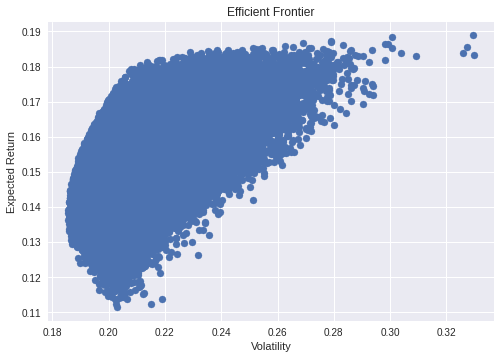

In [ ]:
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, marker='o', cmap=mpl.cm.jet)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

MVO(Mean-Variance Optimization)

In [ ]:
from scipy.optimize import minimize
def obj_sharpe(weights, returns, covmat, rf):
  returns = np.dot(weights, returns)
  vol = np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))
  return 1 / ((returns - rf) / np.sqrt(vol))
n_assets = len(tickers)
covmat = daily_cov*250
rf = 0.01
weights = np.ones([n_assets]) / n_assets
bnds = tuple((0.,1) for i in range(n_assets))
cons = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})
res = minimize(obj_sharpe, weights, (annual_returns, covmat, rf), method='SLSQP', bounds=bnds, constraints=cons)
print(res)
print(np.round(res.x, 3))

     fun: 2.6642855996106025
     jac: array([-1.48708367, -1.48708546, -0.76443967, -1.48704526, -0.81690088])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.18231155e-01, 1.28636391e-01, 0.00000000e+00, 6.53132455e-01,
       3.67788482e-16])
[0.218 0.129 0.    0.653 0.   ]


In [ ]:
returns = np.sum(daily_returns.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
print("return:", returns,"\nvolatility:", vol)

return: 0.18198255826254733 
volatility: 0.20995700285543548


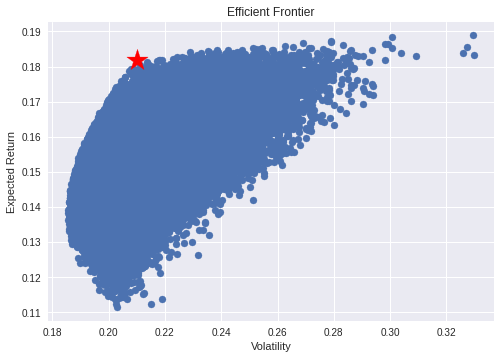

In [ ]:
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, returns, marker='*', c='Red',s=500, alpha=1.0)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

GVO(Global Minimum Optimization)

In [ ]:
from scipy.optimize import minimize
def obj_variance(weights, covmat):
  return np.sqrt(weights.T @ covmat @ weights)
covmat = daily_cov * 250
weights = np.array([0.2,0.2,0.2,0.2,0.2])
bnds = ((0,1),(0,1),(0,1),(0,1),(0,1))
cons = ({'type':'eq','fun': lambda x: np.sum(x)-1})
res = minimize(obj_variance, weights, (covmat), method='SLSQP', bounds=bnds, constraints=cons)
print(res)
print(np.round(res.x, 3))

     fun: 0.1853239885532454
     jac: array([0.18678968, 0.19364163, 0.18577365, 0.18528399, 0.18487719])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 5.72431129e-18, 3.11833976e-01, 4.09286811e-01,
       2.78879213e-01])
[0.    0.    0.312 0.409 0.279]


In [ ]:
returns = np.sum(daily_returns.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
print("return:", returns,"\nvolatility:", vol)

return: 0.13684668314642204 
volatility: 0.1853239885532454


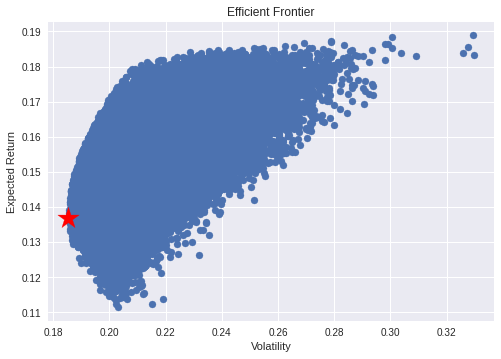

In [ ]:
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, returns, marker='*', c='Red',s=500, alpha=1.0)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

Risk Parity

In [ ]:
print(covmat)

[[0.09256043 0.07164809 0.03653184 0.02675109 0.04413246]
 [0.07164809 0.12582436 0.03684324 0.02547469 0.05027194]
 [0.03653184 0.03684324 0.05082889 0.02423205 0.03098592]
 [0.02675109 0.02547469 0.02423205 0.05078172 0.02136196]
 [0.04413246 0.05027194 0.03098592 0.02136196 0.05714372]]


In [ ]:
def RC(weight, covmat):
  weight = np.array(weight)
  vol = (weight.T @ covmat @ weight) ** 0.5
  mrc = 1/vol * (covmat @ weight)
  rc = weight * mrc
  rc = rc / rc.sum()
  return rc

print(RC([0.2,0.2,0.2,0.2,0.2], covmat))

[0.2439139  0.27843097 0.16111803 0.13344178 0.18309533]


In [ ]:
from scipy.optimize import minimize
def RiskParity_objective(weights):
  vol = (weights.T @ covmat @ weights) ** 0.5
  mrc = 1/vol * (covmat @ weights)
  rc = weights * mrc
  a = np.reshape(rc, (len(rc), 1))
  risk_diffs = a - a.T
  sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
  return sum_risk_diffs_squared

In [ ]:
weights = np.array([0.2,0.2,0.2,0.2,0.2])
bnds = ((0,1),(0,1),(0,1),(0,1),(0,1))
cons = ({'type':'eq','fun': lambda x: np.sum(x)-1})
res = minimize(RiskParity_objective, weights, method='SLSQP', bounds=bnds, constraints=cons)
print(res)
print(np.round(res.x, 3))

     fun: 7.946119225483307e-08
     jac: array([-2.19341798e-04,  4.33452057e-04,  6.50113179e-05, -6.15637168e-05,
       -1.27624941e-04])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.16159695, 0.14582707, 0.22685547, 0.25871537, 0.20700513])
[0.162 0.146 0.227 0.259 0.207]


In [ ]:
returns = np.sum(daily_returns.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
print("return:", returns,"\nvolatility:", vol)

return: 0.15112301870416103 
volatility: 0.20059575944537222


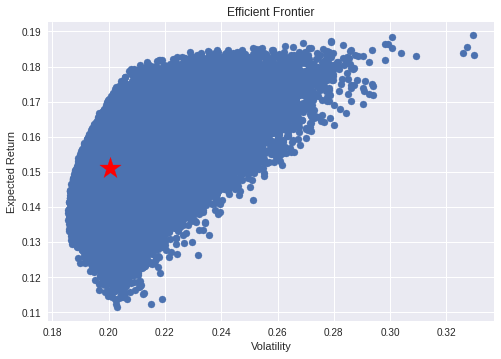

In [ ]:
plt.style.use('seaborn')
plt.scatter(p_volatility, p_returns, marker='o', cmap=mpl.cm.jet)
plt.scatter(vol, returns, marker='*', c='Red',s=500, alpha=1.0)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

Risk Budgeting

In [ ]:
from scipy.optimize import minimize
def RiskBudgeting_objective(weights, risk_budget):
  return np.sum((weights*np.dot(covmat, weights)/np.dot(weights.transpose(), np.dot(covmat, weights))-risk_budget)**2)

In [ ]:
risk_budget = np.array([0.5, 0.2, 0.2, 0.0, 0.1])
weights = np.array([0.2,0.2,0.2,0.2,0.2])
bnds = ((0,1),(0,1),(0,1),(0,1),(0,1))
cons = ({'type':'eq','fun': lambda x: np.sum(x)-1})
res = minimize(RiskBudgeting_objective, weights, risk_budget, method='SLSQP', bounds=bnds, constraints=cons)
print(res)
print(np.round(res.x, 3))

     fun: 7.149630865327446e-07
     jac: array([-0.00061531,  0.00043594,  0.00040893,  0.00087361,  0.00053449])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.42028027, 0.16553826, 0.28213719, 0.00147926, 0.13056502])
[0.42  0.166 0.282 0.001 0.131]


In [ ]:
returns = np.sum(daily_returns.mean() * res['x']) * 250
vol = np.sqrt(res['x'].T @ covmat @ res['x'])
print("return:", returns,"\nvolatility:", vol)

return: 0.15475547021117408 
volatility: 0.23720447055098606
